<h1><center>Siamese Neural Networks to Compare two Signatures</center></h1>

Signature  verification  and  forgery  detection  is  the  process  of  verifying  signatures  automatically  and  instantly  to determine  whether  the  signature  is  real  or  not.  There  are  two  main  kinds  of  signature  verification:  static  and dynamic.  Static,  or  off-line  verification  is  the  process  of  verifying  a  document  signature  after  it  has  been  made, while  dynamic  or  on-line  verificationtakes  place  as  a  person  creates  his/her  signature  on  a  digital  tablet  or  a similar  device.

In this project, the process will be entirely off-line, therefore, the user will have to upload the photo of his/her signature in order to check how similar are the signatures in the dabase versus the photo recently uploaded. If the comparison is over 90% the signature is considered reliable and proceed to certified the document.

In [ ]:
# Import libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score
import seaborn as sns
from shutil import copy
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity
from sklearn.utils import shuffle
import random
import os
np.random.seed(42)

#Set data directory
DATA_DIR = "Input/Dataset"

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Mount Google Colab
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Change working directory.
%cd /gdrive/MyDrive/handwriting2/verisign/

/gdrive/MyDrive/handwriting2/verisign


In [ ]:
def load_data(DATA_DIR=DATA_DIR, test_size=0.2, verbose=True, load_grayscale=True):
    """
        Loads the data into a dataframe.
        
        Arguments:
            DATA_DIR: str
            test_size: float
        Returns:
            (x_train, y_train,x_test, y_test, x_val, y_val, df)
    """
    features = []
    features_forged = []
    features_real = []
    features_dict = {}
    labels = [] # forged: 0 and real: 1
    mode = "rgb"
    if load_grayscale:
        mode = "grayscale"
    
    for folder in os.listdir(DATA_DIR):
        # forged images
        if folder == '.DS_Store' or folder == '.ipynb_checkpoints':
            continue
        print ("Searching folder {}".format(folder))
        for sub in os.listdir(DATA_DIR+"/"+folder+"/forge"):
            f = DATA_DIR+"/"+folder+"/forge/" + sub
            img = load_img(f,color_mode=mode, target_size=(150,150))
            features.append(img_to_array(img))
            features_dict[sub] = (img, 0)
            features_forged.append(img)
            if verbose:
                print ("Adding {} with label 0".format(f))
            labels.append(0) # forged
        # real images
        for sub in os.listdir(DATA_DIR+"/"+folder+"/real"):
            f = DATA_DIR+"/"+folder+"/real/" + sub
            img = load_img(f,color_mode=mode, target_size=(150,150))
            features.append(img_to_array(img))
            features_dict[sub] = (img, 1)
            features_real.append(img)
            if verbose:
                print ("Adding {} with label 1".format(f))
            labels.append(1) # real
            
    features = np.array(features)
    labels = np.array(labels)
    
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
    
    print ("Generated data.")
    return features, labels,features_forged, features_real,features_dict,x_train, x_test, y_train, y_test, x_val, y_val


def convert_label_to_text(label=0):
    """
        Convert label into text
        
        Arguments:
            label: int
        Returns:
            str: The mapping
    """
    return "Forged" if label == 0 else "Real"

In [ ]:
features, labels,features_forged, features_real, features_dict,x_train, x_test, y_train, y_test, x_val, y_val = load_data(verbose=False, load_grayscale=False)

Searching folder Dataset_Signature_Final
Searching folder dataset_signature_final
Searching folder sample_Signature
Searching folder sample_signature
Generated data.


We extract all the data in the respective variables where 0 label stands for forged and 1 stands for real. The images are loaded with as channels as 1 (grayscale) Let us get a closer look at the data.


Distribution: [450 450]


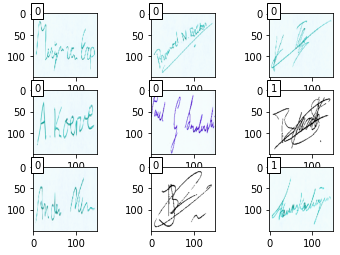

In [ ]:
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(features[0]/255.)
axarr[0,0].text(2, 2, labels[0], bbox={'facecolor': 'white', 'pad': 3})
axarr[0,1].imshow(features[1]/255.)
axarr[0,1].text(2, 2, labels[1], bbox={'facecolor': 'white', 'pad': 3})
axarr[0,2].imshow(features[2]/255.)
axarr[0,2].text(2, 2, labels[2], bbox={'facecolor': 'white', 'pad': 3})
axarr[1,0].imshow(features[300]/255.)
axarr[1,0].text(2, 2, labels[300], bbox={'facecolor': 'white', 'pad': 3})
axarr[1,1].imshow(features[400]/255.)
axarr[1,1].text(2, 2, labels[400], bbox={'facecolor': 'white', 'pad': 3})
axarr[1,2].imshow(features[512]/255.)
axarr[1,2].text(2, 2, labels[512], bbox={'facecolor': 'white', 'pad': 3})
axarr[2,0].imshow(features[6]/255.)
axarr[2,0].text(2, 2, labels[6], bbox={'facecolor': 'white', 'pad': 3})
axarr[2,1].imshow(features[200]/255.)
axarr[2,1].text(2, 2, labels[200], bbox={'facecolor': 'white', 'pad': 3})
axarr[2,2].imshow(features[100]/255.)
axarr[2,2].text(2, 2, labels[100], bbox={'facecolor': 'white', 'pad': 3})

print ("Distribution: {}".format(np.bincount(labels)))

Here we show some snapshots of the signatures.
The distribution of the data is uniform as we have 450 as forged and 450 images as real.
0 represents forged and 1 represents real
The images are loaded with a target_size of (150,150)

## Creating the Convolutional Neural Network

* Keras Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
    * The kernel is an integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. In this case the size of the Kernel is 2.
    * The stride is an integer or tuple/list of 2 integers, specifying the “step” of the convolution along with the height and width of the input volume. Its default value is always set to (1, 1) which means that the given Conv2D filter is applied to the current location of the input volume and the given filter takes a 1-pixel step to the right and again the filter is applied to the input volume and it is performed until we reach the far right border of the volume in which we are moving our filter. In this case the size of the stride is 3.
    * The activation function is simply a convenience parameter which allows you to supply a string, which specifies the name of the activation function you want to apply after performing the convolution. In this case is the relu function.
    * Input shape, this argument is at the first layer in a model, in this case it means that the input for the CNN it's going to be 150x150 pixels with the channels RGB, that's why the number 3 is in there.
* BatchNormalization: Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. Importantly, batch normalization works differently during training and during inference.
    * During training (i.e. when using fit() or when calling the layer/model with the argument training=True), the layer normalizes its output using the mean and standard deviation of the current batch of inputs. That is to say, for each channel being normalized, the layer returns `(batch - mean(batch)) / (var(batch) + epsilon) * gamma + beta`, where:
        * epsilon is small constant (configurable as part of the constructor arguments)
        * gamma is a learned scaling factor (initialized as 1), which can be disabled by passing scale=False to the constructor.
        * beta is a learned offset factor (initialized as 0), which can be disabled by passing center=False to the constructor.
    * During inference (i.e. when using evaluate() or predict() or when calling the layer/model with the argument training=False (which is the default), the layer normalizes its output using a moving average of the mean and standard deviation of the batches it has seen during training. That is to say, it returns `(batch - self.moving_mean) / (self.moving_var + epsilon) * gamma + beta`.
        * self.moving_mean and self.moving_var are non-trainable variables that are updated each time the layer in called in training mode, as such:
            * `moving_mean = moving_mean * momentum + mean(batch) * (1 - momentum)`
            * `moving_var = moving_var * momentum + var(batch) * (1 - momentum)`
    
    As such, the layer will only normalize its inputs during inference after having been trained on data that has similar statistics as the inference data.
* MaxPool2d: We use Max Pooling to reduce the spatial dimensions of the output volume.
![Ejemplo de uso](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)
* Flatten: Flattens the input. Does not affect the batch size. It works converting a matrix into an array.
* Dropout: The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged. The rate is a float between 0 and 1 (in this case is 0.2), this is the fraction of the input units to drop.
* Dense: Dense layer is the regular deeply connected neural network layer. It is most common and frequently used layer. In this case we use two arguments, units and the activation function.
    * units: Positive integer, dimensionality of the output space.
    * activation: Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).

In [ ]:
# the CNN is the diagram
feature_vector = tf.keras.Sequential()
feature_vector.add(tf.keras.layers.Conv2D(2,3, activation='relu', input_shape=(150,150,3)))
feature_vector.add(tf.keras.layers.BatchNormalization())
feature_vector.add(tf.keras.layers.MaxPool2D((2,2)))
feature_vector.add(tf.keras.layers.Flatten())
feature_vector.add(tf.keras.layers.Dropout(0.2))
feature_vector.add(tf.keras.layers.Dense(2, activation='relu'))

In [ ]:
feature_vector.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 2)       56        
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 2)       8         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 10952)             0         
_________________________________________________________________
dropout (Dropout)            (None, 10952)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 21906     
Total params: 21,970
Trainable params: 21,966
Non-trainable params: 4
____________________________________________________

## Creating the Siamese Neural Network

The very first thing to do is set the shape of the inputs, here are considered as `im_a` (image a) and `im_b` (image b).

Then, these two features are encoded with the CNN previously described.

Now, the output is configured, in a variable named combined, this is the Siamese Neural Network. Combined use the next layers:
* Concatenate: Layer that concatenates a list of inputs. It takes as input a list of tensors, all of the same shape except for the concatenation axis, and returns a single tensor that is the concatenation of all inputs.
* BatchNormalization: Previously described.
* Dense: Previously described.
* Activation: Applies an activation function to an output. In this case the activation function is relu.

Now we create the siamese Neural Nework with Model. Model groups layers into an object with training and inference features. In this case, the inputs are the CNN for the two images uploaded, and the output  is the combined variable.

`sm = tf.keras.Model(inputs=[im_a, im_b], outputs=[combined])`

In [ ]:
# creating the siamese network
im_a = tf.keras.layers.Input(shape=(150,150,3))
im_b = tf.keras.layers.Input(shape=(150,150,3))

encoded_a = feature_vector(im_a)
encoded_b = feature_vector(im_b)

combined = tf.keras.layers.concatenate([encoded_a, encoded_b])
combined = tf.keras.layers.BatchNormalization()(combined)
combined = tf.keras.layers.Dense(8, activation = 'linear')(combined)
combined = tf.keras.layers.BatchNormalization()(combined)
combined = tf.keras.layers.Activation('relu')(combined)
combined = tf.keras.layers.Dense(1, activation = 'sigmoid')(combined)

sm = tf.keras.Model(inputs=[im_a, im_b], outputs=[combined])
sm.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2)            21970       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 4)            0           sequential[0][0]      

In [ ]:
sm.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy']) 

#Data Generation Approach #2

In this approach, we try to setup a dataset where we cross multiply each signature with other number signature. The inputs and the outputs must be the same size.

In [ ]:
def generate_data(person_number="001"):
    x = list(features_dict.keys())
    im_r = []
    im_f = []
    labels = [] # represents 1 if signature is real else 0
    for i in x:
        if i.startswith(person_number):
            if i.endswith("{}.png".format(person_number)):
                im_r.append(i)
                labels.append(1)
            else:
                im_f.append(i)
                labels.append(0)
    return im_r, im_f, labels


def generate_dataset_approach_two(size=100, test_size=0.25):
    """
        Generate data using the second approach.
        Remember input and output must be the same size!
        
        Arguments:
            features: numpy array
            labels: numpy array
            size: the target size (length of the array)
        Returns:
            x_train, y_train
    """
    im_r = []
    im_f = []
    ls = []

    ids = ["001","002","003",'004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020','021','022',
           '023','024','025','026','027','028','029','030']
    
    for i in ids:
        imr, imf, labels = generate_data(i)
        
        # similar batch
        for i in imr:
            for j in imr:
                im_r.append(img_to_array(features_dict[i][0]))
                im_f.append(img_to_array(features_dict[j][0]))
                ls.append(1) # they are similar
        
        # not similar batch
        for k in imf:
            for l in imf:
                im_r.append(img_to_array(features_dict[k][0]))
                im_f.append(img_to_array(features_dict[l][0]))
                ls.append(0) # they are not similar
    
    print(len(im_r), len(im_f))
    pairs = np.stack([im_r, im_f], axis=1)
    ls = np.array(ls)
    
    x_train, x_test, y_train, y_test = train_test_split(pairs, ls, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
    return x_train, y_train, x_test, y_test, x_val, y_val, pairs, ls

In [ ]:
x_train, y_train, x_test, y_test, x_val, y_val, pairs, ls = generate_dataset_approach_two()

5019 5019


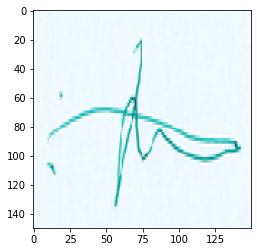

Label:  0


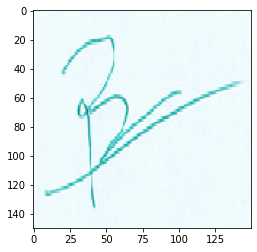

In [ ]:
plt.imshow(x_train[:,0][0]/255.)
plt.show()
plt.imshow(x_train[:,0][1]/255.)
print("Label: ",y_train[0])

Now we have the dataset generated. We will train the network.

In [ ]:
history = sm.fit([x_train[:,0], x_train[:,1]], y_train, epochs=10, validation_data=([x_test[:,0], x_test[:,1]], y_test))

Epoch 1/10
89/89 [==============================] - 56s 625ms/step - loss: 0.3727 - accuracy: 0.9111 - val_loss: 0.2923 - val_accuracy: 0.9291
Epoch 2/10
89/89 [==============================] - 55s 622ms/step - loss: 0.2304 - accuracy: 0.9207 - val_loss: 0.1473 - val_accuracy: 0.9291
Epoch 3/10
89/89 [==============================] - 56s 628ms/step - loss: 0.1524 - accuracy: 0.9221 - val_loss: 0.1400 - val_accuracy: 0.9299
Epoch 4/10
89/89 [==============================] - 55s 623ms/step - loss: 0.1072 - accuracy: 0.9720 - val_loss: 0.1177 - val_accuracy: 0.9992
Epoch 5/10
89/89 [==============================] - 56s 628ms/step - loss: 0.0774 - accuracy: 1.0000 - val_loss: 0.0443 - val_accuracy: 0.9936
Epoch 6/10
89/89 [==============================] - 56s 627ms/step - loss: 0.0524 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9992
Epoch 7/10
89/89 [==============================] - 56s 629ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 0.9992

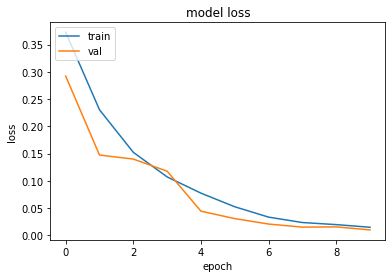

In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(history)

In [ ]:
# save model and architecture to single file
sm.save("prediction-model.h5")
print("Saved model to disk")

Saved model to disk


# Load Model

In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
 
# load model
model = load_model('prediction-model.h5',compile=True)
# summarize model.
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2)            21970       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 4)            0           sequential[0][0]      

In [ ]:
test_path = './Input/my_test/'
genuine = test_path +'test-original.jpg'
real = test_path + 'test-real.jpg'
forged = test_path + 'test-forge.jpg'

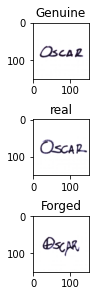

In [ ]:
fig, axs = plt.subplots(3, 1, constrained_layout=True)

# Genuina
gen_img = load_img(genuine,color_mode='rgb', target_size=(150,150))
axs[0].imshow(gen_img)
axs[0].set_title('Genuine')
gen_img = img_to_array(gen_img)
gen_img = tf.expand_dims(gen_img,0)

# Real
r_img = load_img(real,color_mode='rgb', target_size=(150,150))
axs[1].imshow(r_img)
axs[1].set_title('real')
r_img = img_to_array(r_img)
r_img = tf.expand_dims(r_img,0)

# Falsa
for_img = load_img(forged,color_mode='rgb', target_size=(150,150))
axs[2].imshow(for_img)
axs[2].set_title('Forged')
for_img = img_to_array(for_img)
for_img = tf.expand_dims(for_img,0)
plt.show()

In [ ]:
real_deepsign_model = model.predict([gen_img,r_img])
print(f'Predicción real: {real_deepsign_model}')

forged_deepsign_model = model.predict([gen_img,for_img])
print(f'Predicción falsificación: {forged_deepsign_model}')

Predicción real: [[0.9257821]]
Predicción falsificación: [[0.898185]]
